# Lab 3 - Regression
- Structured API Approach

In [2]:
from pyspark.sql import SparkSession
import os

# Set JAVA_HOME explicitly
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-amd64'

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [3]:
spark   

In [4]:
df = spark.read.format('csv').load("/home/aaronpham/Coding/bigdata/spark/spark_mllib/data/nyc-taxi-trip-duration/train.csv", header=True, inferSchema=True)

df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



# Feature Engineering

In [ ]:
from pyspark.sql.functions import hour, dayofweek, month, sqrt, pow, col, when, abs as spark_abs, sin, cos

# Data cleaning - remove extreme outliers (trips < 1 min or > 3 hours)
print("Original data count:", df.count())
df = df.filter((col("trip_duration") >= 60) & (col("trip_duration") <= 10800))
print("After filtering outliers:", df.count())

# Enhanced Feature engineering
df = df.withColumn("pickup_hour", hour(df["pickup_datetime"])) \
       .withColumn("pickup_day", dayofweek(df["pickup_datetime"])) \
       .withColumn("pickup_month", month(df["pickup_datetime"])) \
       .withColumn("haversine_distance", 
                   2 * 6371000 * 
                   sqrt(pow(sin((col("dropoff_latitude") - col("pickup_latitude")) * 3.14159/180 / 2), 2) + 
                        cos(col("pickup_latitude") * 3.14159/180) *
                        cos(col("dropoff_latitude") * 3.14159/180) *
                        pow(sin((col("dropoff_longitude") - col("pickup_longitude")) * 3.14159/180 / 2), 2))) \
       .withColumn("manhattan_distance", 
                   (spark_abs(col("dropoff_latitude") - col("pickup_latitude")) + 
                    spark_abs(col("dropoff_longitude") - col("pickup_longitude"))) * 111000) \
       .withColumn("pickup_lat_bucket", (col("pickup_latitude") * 100).cast("int")) \
       .withColumn("pickup_lon_bucket", (col("pickup_longitude") * 100).cast("int")) \
       .withColumn("dropoff_lat_bucket", (col("dropoff_latitude") * 100).cast("int")) \
       .withColumn("dropoff_lon_bucket", (col("dropoff_longitude") * 100).cast("int")) \
       .withColumn("is_weekend", when((col("pickup_day") == 1) | (col("pickup_day") == 7), 1).otherwise(0)) \
       .withColumn("is_rush_hour", when((col("pickup_hour") >= 7) & (col("pickup_hour") <= 9) | 
                                       (col("pickup_hour") >= 17) & (col("pickup_hour") <= 19), 1).otherwise(0)) \
       .withColumnRenamed("trip_duration", "label")

Original data count: 435203
After filtering outliers: 435203


In [17]:
train, test = df.randomSplit([0.8, 0.2])

train, test

(DataFrame[id: string, vendor_id: int, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: int, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, store_and_fwd_flag: string, label: int, pickup_hour: int, pickup_day: int, pickup_month: int, haversine_distance: double, manhattan_distance: double, pickup_lat_bucket: int, pickup_lon_bucket: int, dropoff_lat_bucket: int, dropoff_lon_bucket: int, is_weekend: int, is_rush_hour: int],
 DataFrame[id: string, vendor_id: int, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: int, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, store_and_fwd_flag: string, label: int, pickup_hour: int, pickup_day: int, pickup_month: int, haversine_distance: double, manhattan_distance: double, pickup_lat_bucket: int, pickup_lon_bucket: int, dropoff_lat_bucket: int, dropoff_lon_bucket: int, is_weekend: int, is_rus

## Preprocess Data

In [18]:
# Replace your existing feature preprocessing cell with this enhanced version
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time

# Define different feature sets for experimentation
feature_sets = {
    "distance_only": ["haversine_distance"],
    "basic_improved": ["passenger_count", "pickup_hour", "pickup_day", "haversine_distance"],
    "distance_focused": ["passenger_count", "pickup_hour", "pickup_day", "vendor_id", 
                        "haversine_distance", "manhattan_distance"],
    "temporal_enhanced": ["passenger_count", "pickup_hour", "pickup_day", "pickup_month",
                         "haversine_distance", "manhattan_distance", "is_weekend", "is_rush_hour"],
    "location_enhanced": ["passenger_count", "pickup_hour", "pickup_day", "pickup_longitude", 
                         "pickup_latitude", "dropoff_longitude", "dropoff_latitude", 
                         "haversine_distance", "manhattan_distance"]
}

## Train Decision Tree Regressor

In [19]:
# Function to train and evaluate model with different feature sets
def train_and_evaluate_model(feature_cols, feature_set_name):
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL WITH: {feature_set_name.upper()}")
    print(f"Features: {feature_cols}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    try:
        # Create VectorAssembler with current feature set
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        
        # Transform train and test data
        # Note: Make sure to use the correct target column name
        train_transformed = assembler.transform(train).select("features", "label")  # Changed from trip_duration to label
        test_transformed = assembler.transform(test).select("features", "label")    # Changed from trip_duration to label
        
        print(f"Training data shape: {train_transformed.count()} rows, {len(feature_cols)} features")
        print(f"Test data shape: {test_transformed.count()} rows")
        
        # Create and train Decision Tree Regressor
        dt = DecisionTreeRegressor(
            featuresCol="features",
            labelCol="label",  # Changed from trip_duration to label
            maxDepth=10,
            maxBins=32,
            minInstancesPerNode=50
        )
        
        # Train the model
        dt_model = dt.fit(train_transformed)
        
        # Make predictions
        predictions = dt_model.transform(test_transformed)
        
        # Create evaluators
        evaluator_rmse = RegressionEvaluator(
            labelCol="label",  # Changed from trip_duration to label
            predictionCol="prediction",
            metricName="rmse"
        )
        
        evaluator_r2 = RegressionEvaluator(
            labelCol="label",  # Changed from trip_duration to label
            predictionCol="prediction",
            metricName="r2"
        )
        
        evaluator_mae = RegressionEvaluator(
            labelCol="label",  # Changed from trip_duration to label
            predictionCol="prediction",
            metricName="mae"
        )
        
        # Calculate metrics
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)
        
        training_time = time.time() - start_time
        
        # Display results
        print(f"\nRESULTS FOR {feature_set_name.upper()}:")
        print(f"Root Mean Square Error (RMSE): {rmse:.2f} seconds")
        print(f"R-squared (R²): {r2:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
        print(f"Training Time: {training_time:.2f} seconds")
        
        # Interpretation
        print(f"\nINTERPRETATION:")
        print(f"• Average prediction error: ~{rmse/60:.1f} minutes")
        print(f"• Model explains {r2*100:.1f}% of variance")
        
        if r2 > 0.8:
            performance = "Excellent"
        elif r2 > 0.6:
            performance = "Good"
        elif r2 > 0.4:
            performance = "Moderate"
        else:
            performance = "Poor"
        print(f"• Performance: {performance}")
        
        return {
            'feature_set': feature_set_name,
            'features': feature_cols,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'training_time': training_time,
            'model': dt_model,
            'predictions': predictions
        }
        
    except Exception as e:
        print(f"Error with feature set {feature_set_name}: {str(e)}")
        return None

# Store results for comparison
results = []

# Train models with different feature sets
for feature_set_name, feature_cols in feature_sets.items():
    # Check if all features exist in the dataset
    available_features = train.columns
    missing_features = [f for f in feature_cols if f not in available_features]
    
    if missing_features:
        print(f"\nSkipping {feature_set_name} - Missing features: {missing_features}")
        print(f"Available features: {available_features}")
        continue
    
    result = train_and_evaluate_model(feature_cols, feature_set_name)
    if result:
        results.append(result)

print(f"\n{'='*80}")
print("COMPARISON OF ALL FEATURE SETS")
print(f"{'='*80}")


TRAINING MODEL WITH: DISTANCE_ONLY
Features: ['haversine_distance']


Training data shape: 348215 rows, 1 features


Test data shape: 86988 rows



RESULTS FOR DISTANCE_ONLY:
Root Mean Square Error (RMSE): 407.80 seconds
R-squared (R²): 0.6177
Mean Absolute Error (MAE): 270.05 seconds
Training Time: 17.09 seconds

INTERPRETATION:
• Average prediction error: ~6.8 minutes
• Model explains 61.8% of variance
• Performance: Good

TRAINING MODEL WITH: BASIC_IMPROVED
Features: ['passenger_count', 'pickup_hour', 'pickup_day', 'haversine_distance']


Training data shape: 348215 rows, 4 features


Test data shape: 86988 rows



RESULTS FOR BASIC_IMPROVED:
Root Mean Square Error (RMSE): 360.95 seconds
R-squared (R²): 0.7005
Mean Absolute Error (MAE): 235.44 seconds
Training Time: 15.09 seconds

INTERPRETATION:
• Average prediction error: ~6.0 minutes
• Model explains 70.0% of variance
• Performance: Good

TRAINING MODEL WITH: DISTANCE_FOCUSED
Features: ['passenger_count', 'pickup_hour', 'pickup_day', 'vendor_id', 'haversine_distance', 'manhattan_distance']


Training data shape: 348215 rows, 6 features


Test data shape: 86988 rows



RESULTS FOR DISTANCE_FOCUSED:
Root Mean Square Error (RMSE): 360.76 seconds
R-squared (R²): 0.7008
Mean Absolute Error (MAE): 235.18 seconds
Training Time: 15.90 seconds

INTERPRETATION:
• Average prediction error: ~6.0 minutes
• Model explains 70.1% of variance
• Performance: Good

TRAINING MODEL WITH: TEMPORAL_ENHANCED
Features: ['passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month', 'haversine_distance', 'manhattan_distance', 'is_weekend', 'is_rush_hour']


Training data shape: 348215 rows, 8 features


Test data shape: 86988 rows



RESULTS FOR TEMPORAL_ENHANCED:
Root Mean Square Error (RMSE): 358.16 seconds
R-squared (R²): 0.7051
Mean Absolute Error (MAE): 233.93 seconds
Training Time: 16.03 seconds

INTERPRETATION:
• Average prediction error: ~6.0 minutes
• Model explains 70.5% of variance
• Performance: Good

TRAINING MODEL WITH: LOCATION_ENHANCED
Features: ['passenger_count', 'pickup_hour', 'pickup_day', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'haversine_distance', 'manhattan_distance']


Training data shape: 348215 rows, 9 features


Test data shape: 86988 rows



RESULTS FOR LOCATION_ENHANCED:
Root Mean Square Error (RMSE): 346.42 seconds
R-squared (R²): 0.7241
Mean Absolute Error (MAE): 224.14 seconds
Training Time: 15.66 seconds

INTERPRETATION:
• Average prediction error: ~5.8 minutes
• Model explains 72.4% of variance
• Performance: Good

COMPARISON OF ALL FEATURE SETS


PERFORMANCE COMPARISON:
      Feature Set  Num Features  RMSE (seconds)  R² Score  MAE (seconds)  Training Time (s)
location_enhanced             9         346.419     0.724        224.143             15.665
temporal_enhanced             8         358.163     0.705        233.928             16.030
 distance_focused             6         360.760     0.701        235.181             15.903
   basic_improved             4         360.953     0.700        235.445             15.092
    distance_only             1         407.805     0.618        270.047             17.089


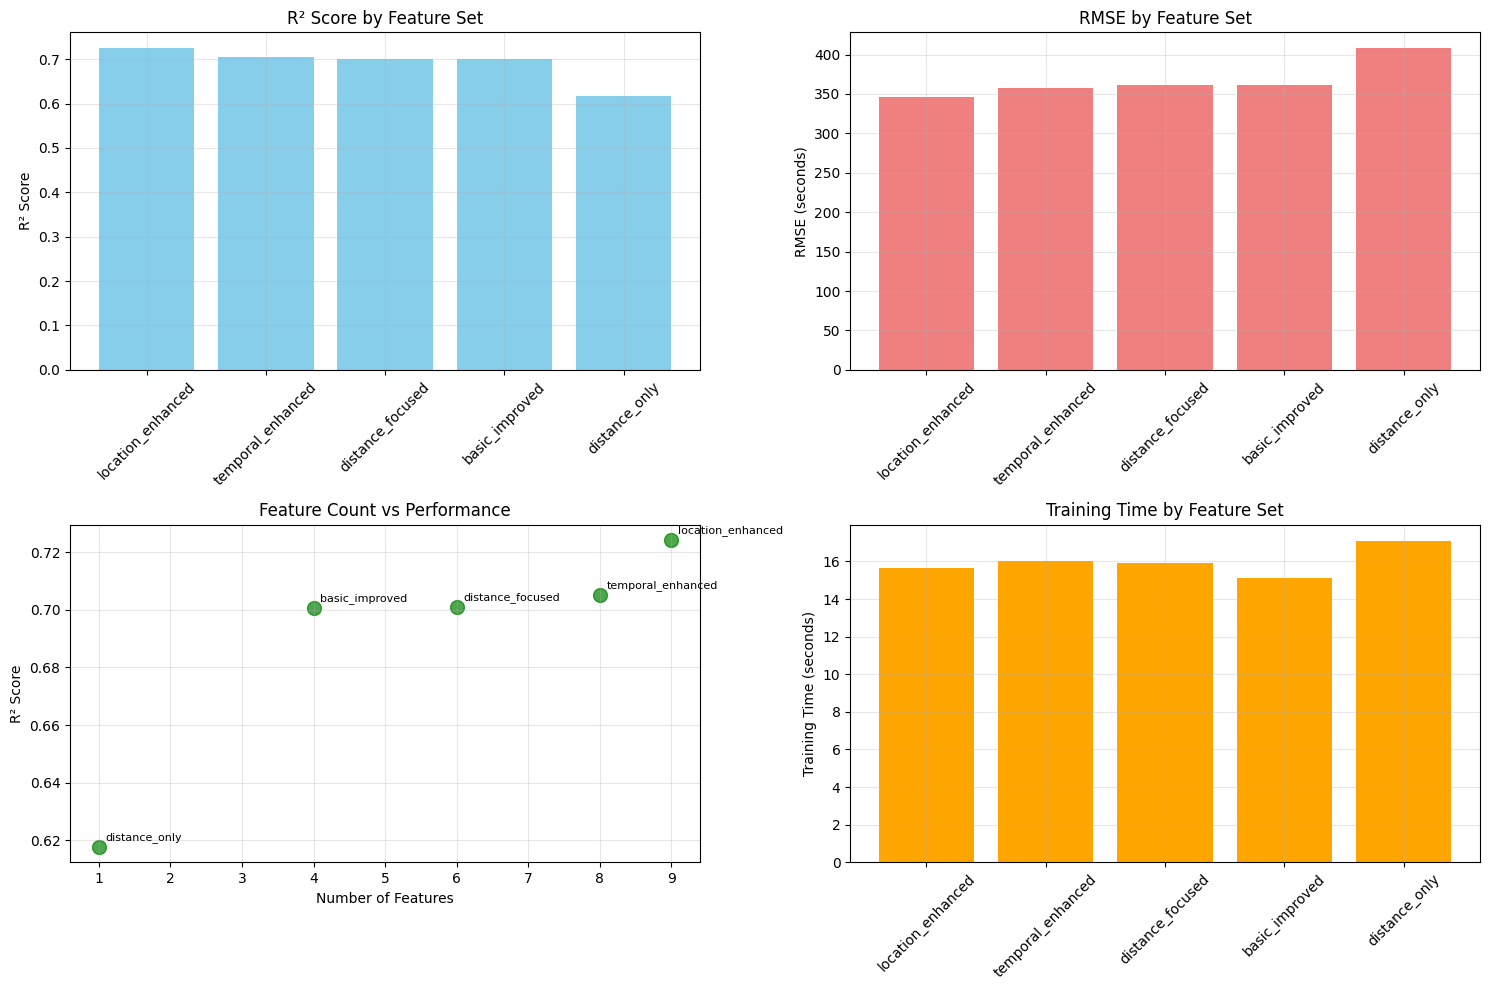


BEST PERFORMING MODEL:
Feature Set: location_enhanced
Features: ['passenger_count', 'pickup_hour', 'pickup_day', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'haversine_distance', 'manhattan_distance']
R² Score: 0.7241
RMSE: 346.42 seconds (5.8 minutes)


In [20]:
# Add this cell to compare results and visualize performance
import matplotlib.pyplot as plt
import pandas as pd

if results:
    # Create comparison DataFrame
    comparison_data = []
    for result in results:
        comparison_data.append({
            'Feature Set': result['feature_set'],
            'Num Features': len(result['features']),
            'RMSE (seconds)': result['rmse'],
            'R² Score': result['r2'],
            'MAE (seconds)': result['mae'],
            'Training Time (s)': result['training_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('R² Score', ascending=False)
    
    print("PERFORMANCE COMPARISON:")
    print(comparison_df.to_string(index=False, float_format='%.3f'))
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # R² Score comparison
    axes[0, 0].bar(comparison_df['Feature Set'], comparison_df['R² Score'], color='skyblue')
    axes[0, 0].set_title('R² Score by Feature Set')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # RMSE comparison
    axes[0, 1].bar(comparison_df['Feature Set'], comparison_df['RMSE (seconds)'], color='lightcoral')
    axes[0, 1].set_title('RMSE by Feature Set')
    axes[0, 1].set_ylabel('RMSE (seconds)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Number of features vs Performance
    axes[1, 0].scatter(comparison_df['Num Features'], comparison_df['R² Score'], 
                      s=100, color='green', alpha=0.7)
    for i, row in comparison_df.iterrows():
        axes[1, 0].annotate(row['Feature Set'], 
                           (row['Num Features'], row['R² Score']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 0].set_xlabel('Number of Features')
    axes[1, 0].set_ylabel('R² Score')
    axes[1, 0].set_title('Feature Count vs Performance')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Training time comparison
    axes[1, 1].bar(comparison_df['Feature Set'], comparison_df['Training Time (s)'], color='orange')
    axes[1, 1].set_title('Training Time by Feature Set')
    axes[1, 1].set_ylabel('Training Time (seconds)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best performing model
    best_model = max(results, key=lambda x: x['r2'])
    print(f"\nBEST PERFORMING MODEL:")
    print(f"Feature Set: {best_model['feature_set']}")
    print(f"Features: {best_model['features']}")
    print(f"R² Score: {best_model['r2']:.4f}")
    print(f"RMSE: {best_model['rmse']:.2f} seconds ({best_model['rmse']/60:.1f} minutes)")
    
else:
    print("No successful results to compare. Check feature availability.")